### 1. Load stock price data

In [1]:
import yfinance as yf
import pandas as pd

# Set ticker
ticker = '005930.KS'

# Load Data
stock_data = yf.download(ticker, start='2023-06-13', end='2024-06-13')
news_data = pd.read_csv('/content/news_data.csv')
dates = stock_data.index

# data = stock_data[['Close', 'Volume']]

# Convert the Date column to datetime in both datasets
news_data['Date'] = pd.to_datetime(news_data['Date'])

# Convert the index to a column
stock_data.reset_index(inplace=True)

# Rename the index column to 'Date'
stock_data.rename(columns={'index': 'Date'}, inplace=True)

# Convert the Date column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge the datasets on the Date column
data = pd.merge(stock_data, news_data, on='Date', how='inner')
data = data[['Close', 'Volume', 'Good', 'Bad', 'Intermediate']]

data.head()

[*********************100%%**********************]  1 of 1 completed


,Close,Volume,Good,Bad,Intermediate
0,72000.0,13227285,1,0,0
1,71900.0,12541046,0,0,1
2,71500.0,13614994,1,0,0
3,71800.0,15373696,1,0,0
4,71200.0,11100887,0,0,1


### 2. Preprocessing

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


# Create sequence data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : i + seq_length]
        y = data[i + seq_length][0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
split = int(0.5 * len(X_test))
X_valid, X_test = X_test[:split], X_test[split:]
y_valid, y_test = y_test[:split], y_test[split:]

# Save dates of test data
test_dates = dates[-19:]

# Check a shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Set DataLoader
import torch
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
valid_data = TensorDataset(
    torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).float()
)
test_data = TensorDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


(148, 60, 5) (148,)
(19, 60, 5) (19,)


### 3. Define LSTM model

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = 5  # Close, Volume, Good, Bad, Intermediate
hidden_size = 64
num_layers = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model = StockPredictor(input_size, hidden_size, num_layers).to(device)

### 4. Train

In [4]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Train
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {loss.item():.4f}")

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))
            print(f"Valid Loss: {loss.item():.4f}")


num_epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/1000]
Train Loss: 0.0454
Valid Loss: 0.1051
Epoch [2/1000]
Train Loss: 0.0627
Valid Loss: 0.0291
Epoch [3/1000]
Train Loss: 0.0546
Valid Loss: 0.0366
Epoch [4/1000]
Train Loss: 0.0410
Valid Loss: 0.0529
Epoch [5/1000]
Train Loss: 0.0433
Valid Loss: 0.0587
Epoch [6/1000]
Train Loss: 0.0382
Valid Loss: 0.0356
Epoch [7/1000]
Train Loss: 0.0248
Valid Loss: 0.0142
Epoch [8/1000]
Train Loss: 0.0255
Valid Loss: 0.0117
Epoch [9/1000]
Train Loss: 0.0155
Valid Loss: 0.0432
Epoch [10/1000]
Train Loss: 0.0105
Valid Loss: 0.1526
Epoch [11/1000]
Train Loss: 0.0095
Valid Loss: 0.2605
Epoch [12/1000]
Train Loss: 0.0149
Valid Loss: 0.0415
Epoch [13/1000]
Train Loss: 0.0082
Valid Loss: 0.0505
Epoch [14/1000]
Train Loss: 0.0092
Valid Loss: 0.0219
Epoch [15/1000]
Train Loss: 0.0119
Valid Loss: 0.0274
Epoch [16/1000]
Train Loss: 0.0112
Valid Loss: 0.0450
Epoch [17/1000]
Train Loss: 0.0079
Valid Loss: 0.0374
Epoch [18/1000]
Train Loss: 0.0072
Valid Loss: 0.0436
Epoch [19/1000]
Train Loss: 0.0093
Va

### 5. Result

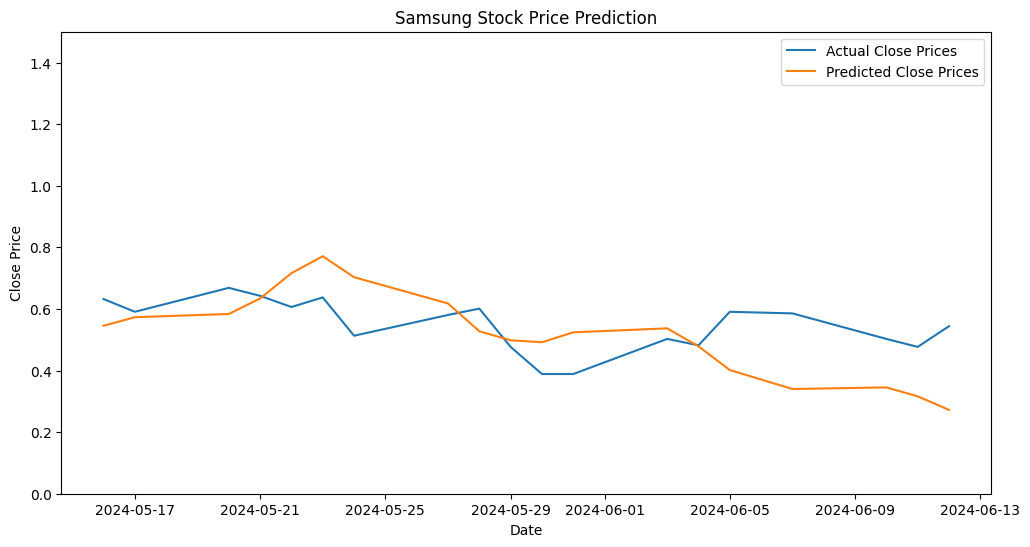

In [5]:
# Result
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())
    return predictions, actuals


predictions, actuals = evaluate_model(model, test_loader)

results = pd.DataFrame(
    {"Date": test_dates, "Actual": actuals, "Predicted": predictions}
)
results.set_index('Date', inplace=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results["Actual"], label="Actual Close Prices")
plt.plot(results["Predicted"], label="Predicted Close Prices")
plt.legend()
plt.title("Samsung Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.ylim(0, 1.5)
plt.show()